# Stage 5, Report

https://github.com/anhaidgroup/py_entitymatching/blob/master/notebooks/vldb_demo/Demo_notebook_v6.ipynb

In [2]:
import py_entitymatching as em
import os
import pandas as pd

# specify filepaths for tables A and B. 
path_A = 'tableA.csv'
path_B = 'tableB.csv'
# read table A; table A has 'ID' as the key attribute
A = em.read_csv_metadata(path_A, key='id')
# read table B; table B has 'ID' as the key attribute
B = em.read_csv_metadata(path_B, key='id')

ImportError: No module named py_entitymatching

# Filling in Missing Values

In [3]:
# Impute missing values

# Manually set metadata properties, as current py_entitymatching.impute_table()
# requires 'fk_ltable', 'fk_rtable', 'ltable', 'rtable' properties
em.set_property(A, 'fk_ltable', 'id')
em.set_property(A, 'fk_rtable', 'id')
em.set_property(A, 'ltable', A)
em.set_property(A, 'rtable', A)

A_all_attrs = list(A.columns.values)
A_impute_attrs = ['year','min_num_players','max_num_players','min_gameplay_time','max_gameplay_time','min_age']
A_exclude_attrs = list(set(A_all_attrs) - set(A_impute_attrs))
A1 = em.impute_table(A, exclude_attrs=A_exclude_attrs, missing_val='NaN', strategy='most_frequent', axis=0, val_all_nans=0, verbose=True)

# Compare number of missing values to check the results
print(sum(A['min_num_players'].isnull()))
print(sum(A1['min_num_players'].isnull()))

# Do the same thing for B
em.set_property(B, 'fk_ltable', 'id')
em.set_property(B, 'fk_rtable', 'id')
em.set_property(B, 'ltable', B)
em.set_property(B, 'rtable', B)

B_all_attrs = list(B.columns.values)
# TODO: add 'min_age'
B_impute_attrs = ['year','min_num_players','max_num_players','min_gameplay_time','max_gameplay_time']
B_exclude_attrs = list(set(B_all_attrs) - set(B_impute_attrs))
B1 = em.impute_table(B, exclude_attrs=B_exclude_attrs, missing_val='NaN', strategy='most_frequent', axis=0, val_all_nans=0, verbose=True)

# Compare number of missing values to check the results
print(sum(B['min_num_players'].isnull()))
print(sum(B1['min_num_players'].isnull()))


65
0
5244
0


In [6]:
# Load the pre-labeled data
S = em.read_csv_metadata('sample_labeled.csv', 
                         key='_id',
                         ltable=A1, rtable=B1, 
                         fk_ltable='ltable_id', fk_rtable='rtable_id')

path_total_cand_set = 'candidate_set_C1.csv'
total_cand_set = em.read_csv_metadata(path_total_cand_set, 
                         key='_id',
                         ltable=A1, rtable=B1, 
                         fk_ltable='ltable_id', fk_rtable='rtable_id')

In [7]:
# Split S into I an J
IJ = em.split_train_test(S, train_proportion=0.75, random_state=35)
I = IJ['train']
J = IJ['test']

In [8]:
corres = em.get_attr_corres(A1, B1)

{'rtable':           id  \
0          1   
1          2   
2          3   
3          4   
4          5   
5          6   
6          7   
7          8   
8          9   
9         10   
10        11   
11        12   
12        13   
13        14   
14        15   
15        16   
16        17   
17        18   
18        19   
19        20   
20        21   
21        22   
22        23   
23        24   
24        25   
25        26   
26        27   
27        28   
28        29   
29        30   
...      ...   
10266  10269   
10267  10270   
10268  10271   
10269  10272   
10270  10273   
10271  10274   
10272  10275   
10273  10276   
10274  10277   
10275  10278   
10276  10279   
10277  10280   
10278  10281   
10279  10282   
10280  10283   
10281  10284   
10282  10285   
10283  10286   
10284  10287   
10285  10288   
10286  10289   
10287  10290   
10288  10291   
10289  10292   
10290  10293   
10291  10294   
10292  10295   
10293  10296   
10294  10297   
10295  10298 

# Generating Features

Here, we generate all the features we decided upon after our final iteration of cross validation and debugging. We only use the relevant subset of all these features in the reported iterations below.

In [9]:
# Generate a set of features
#import pdb; pdb.set_trace();
import py_entitymatching.feature.attributeutils as au
import py_entitymatching.feature.simfunctions as sim
import py_entitymatching.feature.tokenizers as tok

ltable = A1
rtable = B1

# Get similarity functions for generating the features for matching
sim_funcs = sim.get_sim_funs_for_matching()
# Get tokenizer functions for generating the features for matching
tok_funcs = tok.get_tokenizers_for_matching()

# Get the attribute types of the input tables
attr_types_ltable = au.get_attr_types(ltable)
attr_types_rtable = au.get_attr_types(rtable)

# Get the attribute correspondence between the input tables
attr_corres = au.get_attr_corres(ltable, rtable)
print(attr_types_ltable['name'])
print(attr_types_rtable['name'])
attr_types_ltable['name'] = 'str_bt_5w_10w'
attr_types_rtable['name'] = 'str_bt_5w_10w'



# Get the features
F = em.get_features(ltable, rtable, attr_types_ltable,
                                 attr_types_rtable, attr_corres,
                                 tok_funcs, sim_funcs)

#F = em.get_features_for_matching(A1, B1)
print(F['feature_name'])

# Convert the I into a set of feature vectors using F
# Here, we add name edit distance as a feature
include_features_2 = [
    'min_num_players_min_num_players_lev_dist',
    'max_num_players_max_num_players_lev_dist',
    'min_gameplay_time_min_gameplay_time_lev_dist',
    'max_gameplay_time_max_gameplay_time_lev_dist',
    'name_name_lev_dist'
]
F_2 = F.loc[F['feature_name'].isin(include_features_2)]

str_bt_1w_5w
str_bt_5w_10w
0                                           id_id_exm
1                                           id_id_anm
2                                      id_id_lev_dist
3                                       id_id_lev_sim
4                           name_name_jac_qgm_3_qgm_3
5                       name_name_cos_dlm_dc0_dlm_dc0
6                                       name_name_mel
7                                  name_name_lev_dist
8                                   name_name_lev_sim
9                                       year_year_exm
10                                      year_year_anm
11                                 year_year_lev_dist
12                                  year_year_lev_sim
13                   num_players_num_players_lev_dist
14                    num_players_num_players_lev_sim
15                        num_players_num_players_jar
16                        num_players_num_players_jwn
17                        num_players_num_players_exm
1

# Generate training set

In [11]:
# Apply train, test set evaluation
I_table = em.extract_feature_vecs(I, feature_table=F_2, attrs_after='label', show_progress=False)
J_table = em.extract_feature_vecs(J, feature_table=F_2, attrs_after='label', show_progress=False)

In [52]:
total_cand_set_features = em.extract_feature_vecs(total_cand_set, feature_table=F_2, show_progress=False)

m = em.LogRegMatcher(name='LogReg', random_state=0)

m.fit(table=I_table, exclude_attrs=['_id', 'ltable_id', 'rtable_id','label'], target_attr='label')

total_cand_set_features['prediction'] = m.predict(
    table=total_cand_set_features, 
    exclude_attrs=['_id', 'ltable_id', 'rtable_id'],
)

# Joining Tables

In [55]:
# Join tables on matched tuples
match_tuples = total_cand_set_features[total_cand_set_features['prediction']==1]
match_tuples = match_tuples[['ltable_id','rtable_id']]
A1['ltable_id'] = A1['id']
B1['rtable_id'] = B1['id']
joined_tables = pd.merge(match_tuples, A1, how='left', on='ltable_id')
joined_tables = pd.merge(joined_tables, B1, how='left', on='rtable_id')


In [56]:

for n in A1.columns: 
    if not n in ['_id', 'ltable_id', 'rtable_id']:
        joined_tables[n] =  joined_tables.apply((lambda row: row[n+'_y'] if pd.isnull(row[n+'_x']) else row[n+'_x']), axis=1)
        joined_tables = joined_tables.drop(n+'_x', axis=1).drop(n+'_y',axis=1)

joined_tables.to_csv('joined_table.csv')

In [43]:
joined_tables

Index([u'id', u'ltable_id', u'rtable_id', u'id.1', u'name', u'year', u'rating',
       u'rank', u'num_players', u'min_num_players', u'max_num_players',
       u'gameplay_time', u'min_gameplay_time', u'max_gameplay_time',
       u'min_age', u'complexity_weight', u'category', u'mechanisms', u'type',
       u'BGG_link', u'store_names', u'store_prices', u'links_to_buy',
       u'availability', u'international_store'],
      dtype='object')

# Adventure Time!

In [22]:
import pandas as pd
import matplotlib as plt
from scipy.stats.stats import pearsonr
%matplotlib inline

joined_tables = pd.read_csv('joined_table.csv')

In [48]:
joined_tables.columns
print 'Size: ' + str(len(joined_tables))
for c in joined_tables.columns:
    print c + ' : '+ str(sum(joined_tables[c].isnull()))


Size: 563
id : 0
ltable_id : 0
rtable_id : 0
id.1 : 0
name : 0
year : 0
rating : 5
rank : 169
num_players : 0
min_num_players : 0
max_num_players : 0
gameplay_time : 0
min_gameplay_time : 0
max_gameplay_time : 0
min_age : 0
complexity_weight : 39
category : 1
mechanisms : 49
type : 178
BGG_link : 0
store_names : 0
store_prices : 0
links_to_buy : 0
availability : 0
international_store : 0


0

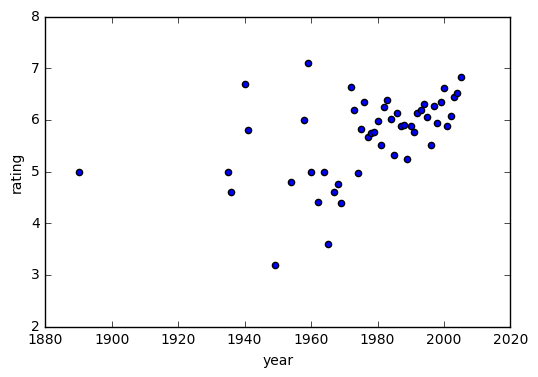

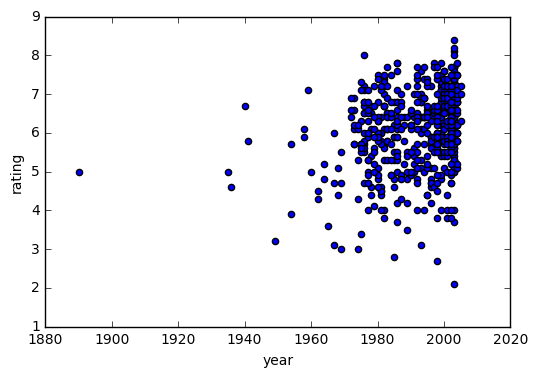

In [41]:
# Rating vs year
joined_tables.groupby('year').agg({'year': 'mean','rating': 'mean'}).plot.scatter(x='year', y='rating')

joined_tables.plot.scatter(x='year', y='rating')
pearsonr(
    joined_tables['year'][joined_tables['rating'].notnull()],
    joined_tables['rating'][joined_tables['rating'].notnull()]
)



(-0.018067907504713075, 0.67987091649355857)

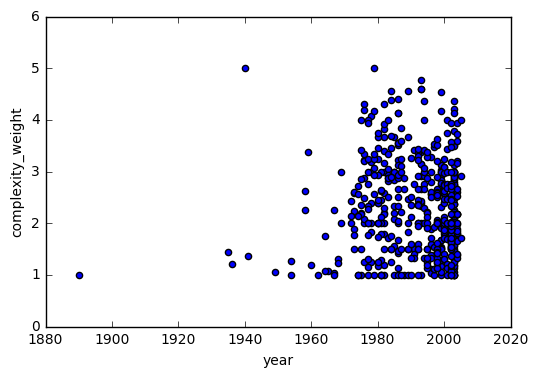

In [30]:
# Complexity weight vs year

joined_tables.plot.scatter(x='year', y='complexity_weight')
pearsonr(joined_tables['year'][joined_tables['complexity_weight'].notnull()],joined_tables['complexity_weight'][joined_tables['complexity_weight'].notnull()])

KeyError: 0